In [9]:
%matplotlib notebook
#%matplotlib inline
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(1234)
from astropy.io import fits
import astropy.units as u
import pandas as pd
from astropy.table import Table
from matplotlib import colors,cm
from tqdm import tqdm

In [ ]:
# Loading BAT data of Vela X-1 and looking info
vela_file = 'data/bat_Vela_X-1_lc-8.fits'
fits.info(vela_file)

In [ ]:
# See HEADER file for further info
hdu = fits.open(vela_file)
hdu[1].header

In [ ]:
# LOAD data with PANDAS and look at the EVENT table
vela_ft = fits.open(vela_file)[1].data
vela = Table.read(vela_file).to_pandas()
vela

In [ ]:
# Some statistical vaues (# events, min, max, mean, std, ...)
vela.describe()

In [ ]:
# Plot LC
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.set_title('Vela LC')
ax.set_xlabel('Time [MJD]')
ax.set_ylabel('Rate [A.U.]')
ax.set_xlim(vela['TIME'].min(),vela['TIME'].max())
ax.errorbar(vela['TIME'],vela['RATE'],xerr=0.5*vela['TIMEDEL']*vela['FRACEXP'],yerr=vela['ERROR'],label='Vela X-1',ls='')
#ax.errorbar(vela['TIME'][vela['FRACEXP']>1],vela['RATE'][vela['FRACEXP']>1],xerr=0.5*vela['TIMEDEL'][vela['FRACEXP']>1]*vela['FRACEXP'][vela['FRACEXP']>1],yerr=vela['ERROR'][vela['FRACEXP']>1],label='FRACEXP>1',ls='')

In [ ]:
# Plot RATE histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.set_title('Vela X-1 histogram of RATE')
ax.set_xlabel('Vela[RATE]')
ax.hist(vela['RATE'], bins=500)#, range=[-0.01,0.05])
ax.axvline(0,ls=':',color='k')

In [ ]:
# Plot only events whose RATE is: 0 > RATE > 0.002
#vela[np.logical_and(vela['PHASE']>i/bin,vela['PHASE']<(i+1)/bin)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.set_title('Vela X-1 MINIMUM fluxes')
ax.set_xlabel('Time [MJD]')
ax.set_ylabel('Rate [A.U.]')
ax.set_xlim(vela['TIME'].min(),vela['TIME'].max())
mask = np.logical_and(vela['RATE']>0,vela['RATE']<0.002)
ax.errorbar(vela['TIME'][mask],
            vela['RATE'][mask],
            xerr=0.5*vela['TIMEDEL'][mask]*vela['FRACEXP'][mask],
            yerr=vela['ERROR'][mask],
            label='Vela X-1',ls='')
ax.plot(vela['TIME'][mask],vela['RATE'][mask],ls='',marker='.',c='r')

## REFERENCES to Lomb-Scargle
1) N.R. Lomb “Least-squares frequency analysis of unequally spaced data”, Astrophysics and Space Science, vol 39, pp. 447-462, 1976

2) J.D. Scargle “Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data”, The Astrophysical Journal, vol 263, pp. 835-853, 1982

3) R.H.D. Townsend, “Fast calculation of the Lomb-Scargle periodogram using graphics processing units.”, The Astrophysical Journal Supplement Series, vol 191, pp. 247-253, 2010

...in few words, Lomb-Scargle is a combination of Fourier Analysis and Least-Square Analysis...

More info and methods comparison can be found on this nice paper of VanderPlas:

https://iopscience.iop.org/article/10.3847/1538-4365/aab766/pdf

In [ ]:
# Basic example of 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))
ax[0].set(title='Sinusoidal function', xlabel='x', ylabel='y')
ax[1].set(title='Lomb-Scargle periodogram', xlabel='Frequency', ylabel='PSD')

for frac_points in [0.9]:
    for w in [1,2,3]:
        for nin in [1000]:
            A = 2.
            phi = 0.5 * np.pi
            nout = 100000
            
            #Randomly select a fraction of an array with timesteps:
            r = np.random.rand(nin)
            x = np.linspace(0.01, 10, nin)
            x = x[r >= frac_points]
            
            #Plot a sine wave for the selected times:
            y = A * np.sin(w*x+phi) + 1*r[r >= frac_points]
            
            #Define the array of frequencies for which to compute the periodogram:
            f = np.linspace(0.01, 10, nout)
            
            #Calculate Lomb-Scargle periodogram:
            pgram = signal.lombscargle(x, y, f, normalize=True)
            
            #Now make a plot of the input data:
            ax[0].plot(x, y, '+:', label='freq=%s' %(w))
            
            #Then plot the normalized periodogram:
            ax[1].plot(f, pgram, label='freq=%s' %(w))
ax[0].legend()
ax[1].legend()
fig.tight_layout()

In [ ]:
# Looking for the PERIODICITY
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))

# Select a small TIME range and FILTER OUT negative values
mask = np.logical_and(vela['RATE']>0,vela['TIME']<53600)
x = vela['TIME'][mask]
y = vela['RATE'][mask]

# Define the array of frequencies for which to compute the periodogram:
nout=100000
period = np.logspace(-1, 2, nout) # from 0.1 day to 100 days
ang_freqs = 2 * np.pi / period

# Calculate Lomb-Scargle periodogram:
# (weak periodic signal with unven sampling)
pgram = signal.lombscargle(x, y-y.mean(), ang_freqs, normalize=True)

#Now make a plot of the input data:
ax[0].plot(x, y, '+')
ax[0].set(xlabel='Time [MJD]',ylabel='Rate [A.U.]',title='Vela X-1 LC')

#Then plot the normalized periodogram:
ax[1].plot(period, pgram)
ax[1].set(xlabel='period [days]',ylabel='A.U.',title='Periodogram: Lomb-Scargle')
for i,j in zip(period,pgram):
    if j==pgram.max():
        print('Best period = %s' % i)
fig.tight_layout()

In [ ]:
# Refine search with SMALLE LINEAR range PERIOD: 0-15 days
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))

# Define the array of frequencies for which to compute the periodogram:
p = np.linspace(0.1, 15, nout)
ang_freqs = 2 * np.pi / p

# Calculate Lomb-Scargle periodogram:
pgram = signal.lombscargle(x, y-y.mean(), ang_freqs, normalize=True)

# Plot of the results:
ax[0].plot(x, y, '+')
ax[0].set(xlabel='Time [MJD]',ylabel='Rate [A.U.]',title='Vela X-1 LC')
ax[1].plot(p, pgram)
ax[1].set(xlabel='period [days]',ylabel='A.U.',title='Periodogram: Lomb-Scargle')

for i,j in zip(p,pgram):
    if j==pgram.max():
        print('Best period = %s' % i)
fig.tight_layout()

<IPython.core.display.Javascript object>


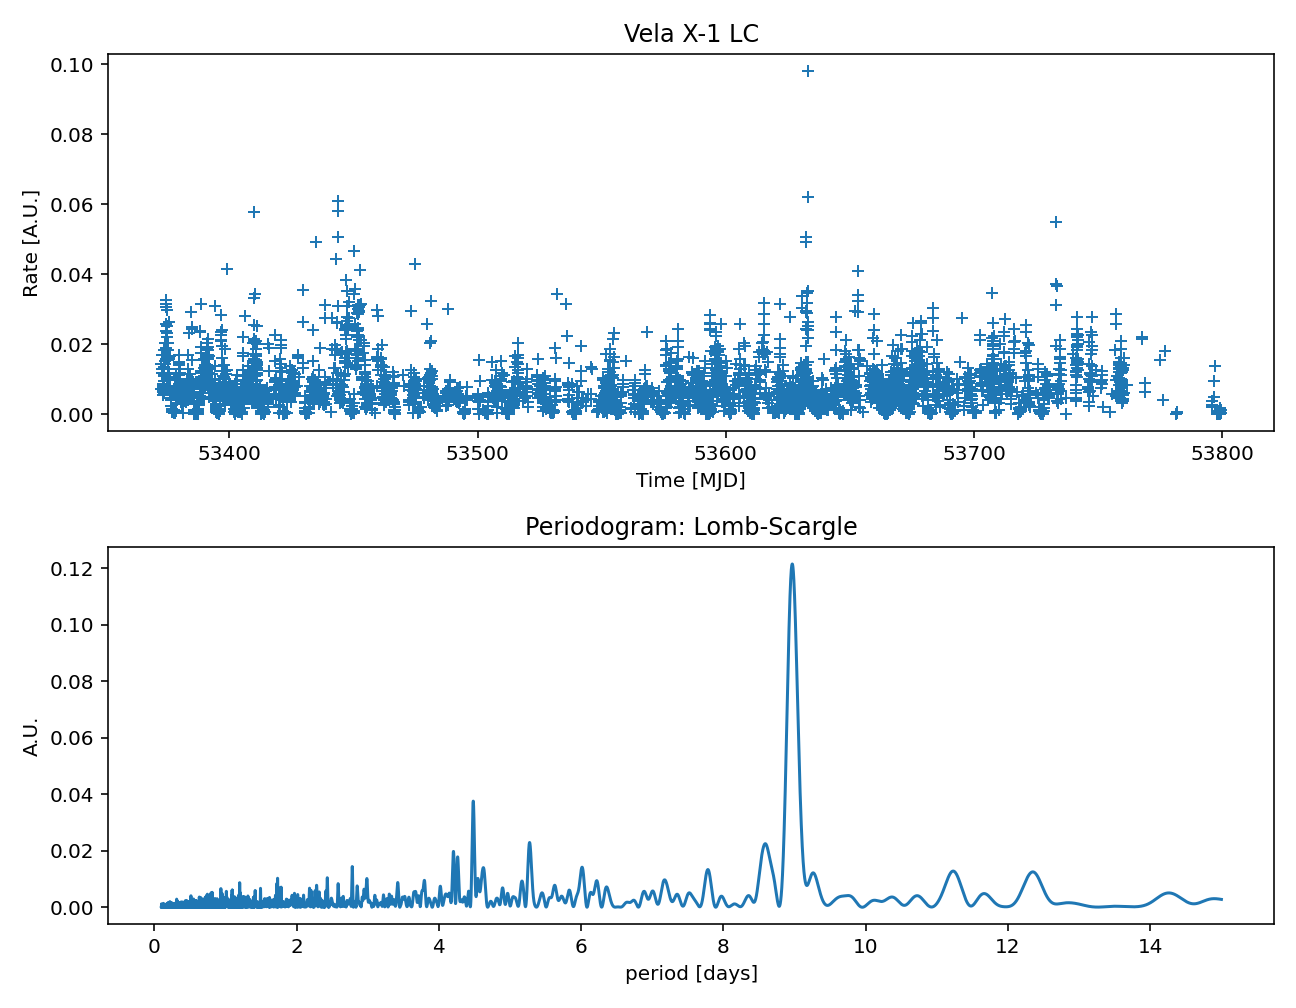

Best period = 8.967823678236783


In [17]:
'''
# Use a LARGER sample of data
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))

# Select TIME range and FILTER OUT negative values
tmax = 53800
mask = np.logical_and(vela['RATE']>0,vela['TIME']<tmax)
x = vela['TIME'][mask]
y = vela['RATE'][mask]

# Define the array of frequencies for which to compute the periodogram:
nout=100000
p = np.linspace(0.1, 15, nout)
ang_freqs = 2 * np.pi / p

# Calculate Lomb-Scargle periodogram:
pgram = signal.lombscargle(x, y-y.mean(), ang_freqs, normalize=True)

# Plot of the results:
ax[0].plot(x, y, '+')
ax[0].set(xlabel='Time [MJD]',ylabel='Rate [A.U.]',title='Vela X-1 LC')
ax[1].plot(p, pgram)
ax[1].set(xlabel='period [days]',ylabel='A.U.',title='Periodogram: Lomb-Scargle')

for i,j in zip(p,pgram):
    if j==pgram.max():
        print('Best period = %s' % i)
fig.tight_layout()
'''

In [ ]:
'''
# Use ALL available data: VERY SLOW
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))

# Select TIME range and FILTER OUT negative values
tmax = vela['TIME'].max()
mask = np.logical_and(vela['RATE']>0,vela['TIME']<tmax)
x = vela['TIME'][mask]
y = vela['RATE'][mask]

# Define the array of frequencies for which to compute the periodogram:
nout=100000
p = np.linspace(0.1, 15, nout)
ang_freqs = 2 * np.pi / p

# Calculate Lomb-Scargle periodogram:
pgram = signal.lombscargle(x, y-y.mean(), ang_freqs, normalize=True)

# Plot of the results:
ax[0].plot(x, y, '+')
ax[0].set(xlabel='Time [MJD]',ylabel='Rate [A.U.]',title='Vela X-1 LC')
ax[1].plot(p, pgram)
ax[1].set(xlabel='period [days]',ylabel='A.U.',title='Periodogram: Lomb-Scargle')

for i,j in zip(p,pgram):
    if j==pgram.max():
        print('Best period = %s' % i)
fig.tight_layout()
'''

## Determination of period and amplitude from epoch folding

https://ui.adsabs.harvard.edu/abs/1987A%26A...180..275L/abstract

In [ ]:
def binned_plot(bin,arr,ax):
    avg,avg_err,avg_err_mean=[],[],[]
    for i in range(bin):
        a = arr[np.logical_and(arr['PHASE']>i/bin,arr['PHASE']<(i+1)/bin)]
        avg.append(a.RATE.mean())
        avg_err.append(np.sqrt((a.ERROR*a.ERROR).sum())/len(a.ERROR))
        avg_err_mean.append(a.ERROR.mean())
    ax.errorbar(np.linspace(0,1,bin),avg,xerr=0.5/bin,yerr=avg_err,ls=':',label='%s bin' % bin)
    ax.axhline(0,ls='--')
    return

# Create FOLDED LC
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(9,25))
fig.suptitle('Vela X-1 FOLDED LC:')
for m,period in enumerate([8.93942351813576,
                           8.939215392153923,                           
                           8.967823678236783,
                           8.96558865588656,
                           8.96409864098641,
                           8.964357]):
    vela['PHASE'] = np.zeros(len(vela['TIME']))
    for n,t in enumerate(vela['TIME']):
        #vela.at[n,'PHASE'] = (t % period)/period
        vela.at[n,'PHASE'] = (t / period)%1
    ax[m,0].set(title='ALL data, P=%.4f' % period, xlabel='Phase', ylabel='RATE [#/s]', ylim=(-0.01,0.05))
    ax[m,0].plot(vela['PHASE'],vela['RATE'],',')
    
    binned_plot(30,vela,ax[m,1])
    ax[m,1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='RATE [#/s]', ylim=(-0.0007,0.012))
    binned_plot(200,vela,ax[m,1])    
    ax[m,1].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

<IPython.core.display.Javascript object>


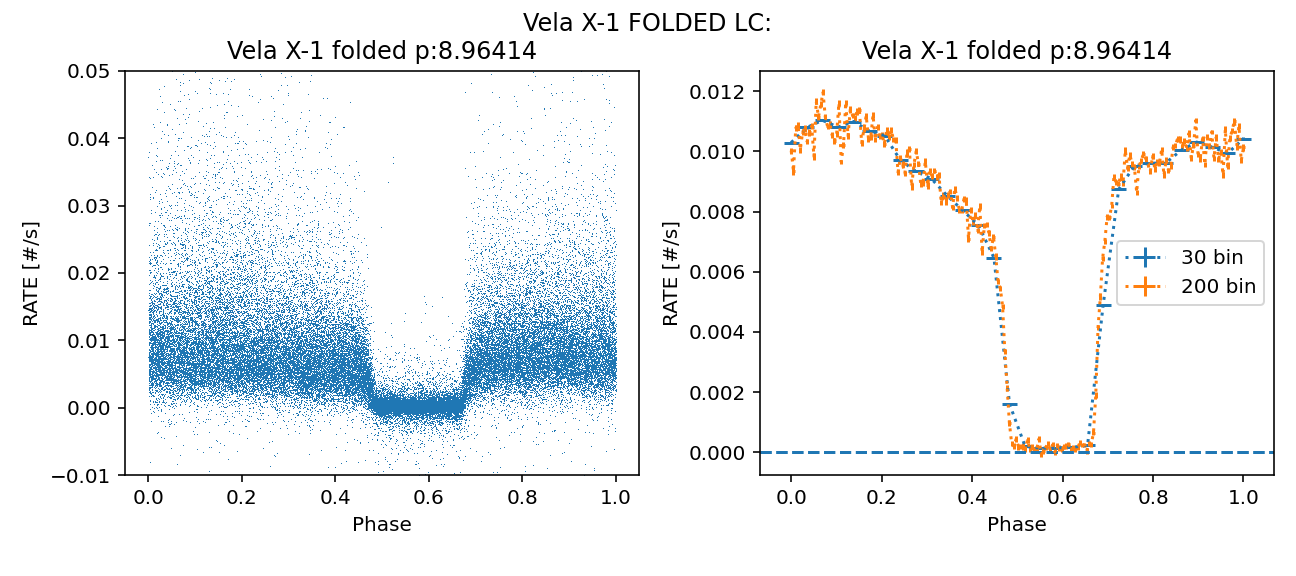

period bin_min best_period max_bin_min
p = 8.96000	b = 14	bp = 8.96000	bb = 14
p = 8.96010	b = 15	bp = 8.96010	bb = 15
p = 8.96020	b = 16	bp = 8.96020	bb = 16
p = 8.96030	b = 17	bp = 8.96030	bb = 17
p = 8.96040	b = 18	bp = 8.96040	bb = 18
p = 8.96051	b = 17	bp = 8.96040	bb = 18
p = 8.96061	b = 19	bp = 8.96061	bb = 19
p = 8.96071	b = 20	bp = 8.96071	bb = 20
p = 8.96081	b = 20	bp = 8.96071	bb = 20
p = 8.96091	b = 21	bp = 8.96091	bb = 21
p = 8.96101	b = 21	bp = 8.96091	bb = 21
p = 8.96111	b = 21	bp = 8.96091	bb = 21
p = 8.96121	b = 23	bp = 8.96121	bb = 23
p = 8.96131	b = 24	bp = 8.96131	bb = 24
p = 8.96141	b = 25	bp = 8.96141	bb = 25
p = 8.96152	b = 25	bp = 8.96141	bb = 25
p = 8.96162	b = 26	bp = 8.96162	bb = 26
p = 8.96172	b = 27	bp = 8.96172	bb = 27
p = 8.96182	b = 27	bp = 8.96172	bb = 27
p = 8.96192	b = 27	bp = 8.96172	bb = 27
p = 8.96202	b = 28	bp = 8.96202	bb = 28
p = 8.96212	b = 29	bp = 8.96212	bb = 29
p = 8.96222	b = 29	bp = 8.96212	bb = 29
p = 8.96232	b = 30	bp = 8.96232	bb = 30
p

In [22]:
'''
## TAKE SOME MINUTES TO EXECUTE
# Fine tune the periodicity, looking for the PERIOD which MAXIMIZE the ECLIPSE
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
fig.suptitle('Vela X-1 FOLDED LC:')
max_bin_min = 0
best_period = 0
print('period bin_min best_period max_bin_min')
for period in np.linspace(8.96,8.97,100):
    vela['PHASE'] = np.zeros(len(vela['TIME']))
    for n,t in enumerate(vela['TIME']):
        vela.at[n,'PHASE'] = (t % period)/period

    avg,avg_err,avg_err_mean=[],[],[]
    bin=200
    bin_min = 0
    for i in range(bin):
        a = vela[np.logical_and(vela['PHASE']>i/bin,vela['PHASE']<(i+1)/bin)]
        avg.append(a.RATE.mean())
        avg_err.append(np.sqrt((a.ERROR*a.ERROR).sum())/len(a.ERROR))
        avg_err_mean.append(a.ERROR.mean())
        if avg[-1] + avg_err[-1] < 0.002:
            bin_min += 1
    if bin_min > max_bin_min:
        max_bin_min = bin_min
        best_period = period
    print('p = %.5f\tb = %s\tbp = %.5f\tbb = %s' % (period,bin_min,best_period,max_bin_min))

# Redo the plot with the BEST PERIOD
vela['PHASE'] = np.zeros(len(vela['TIME']))
for n,t in enumerate(vela['TIME']):
    vela.at[n,'PHASE'] = (t % best_period)/best_period
ax[0].set(title='Vela X-1 folded p:%.5f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')
ax[0].plot(vela['PHASE'],vela['RATE'],',')
ax[0].set_ylim(-0.01,0.05)

binned_plot(30,vela,ax[1])
ax[1].set(title='Vela X-1 folded p:%.5f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')

binned_plot(200,vela,ax[1])
ax[1].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
'''

In [ ]:
# Fine tune the periodicity and look for the PERIOD which MAXIMIZE the ECLIPSE length
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Vela X-1 FOLDED LC:')

max_bin_min = 0
best_period = 0
bin=200
period_list = []
width_eclipse = []
print('period bin_min best_period max_bin_min')
for period in np.linspace(8.963,8.966,30):
    vela['PHASE'] = np.zeros(len(vela['TIME']))
    for n,t in enumerate(vela['TIME']):
        vela.at[n,'PHASE'] = (t % period)/period    
    avg,avg_err,avg_err_mean=[],[],[]
    bin_min = 0
    for i in range(bin):
        a = vela[np.logical_and(vela['PHASE']>i/bin,vela['PHASE']<(i+1)/bin)]
        avg.append(a.RATE.mean())
        avg_err.append(np.sqrt((a.ERROR*a.ERROR).sum())/len(a.ERROR))
        avg_err_mean.append(a.ERROR.mean())
        if avg[-1] + avg_err[-1] < 0.002:
            bin_min += 1
    width_eclipse.append(bin_min)
    period_list.append(period)
    if bin_min > max_bin_min:
        max_bin_min = bin_min
        best_period = period
    print('p = %.5f\tb = %s\tbp = %.5f\tbb = %s' % (period,bin_min,best_period,max_bin_min))

# Redo the plot with the BEST PERIOD
vela['PHASE'] = np.zeros(len(vela['TIME']))
for n,t in enumerate(vela['TIME']):
    vela.at[n,'PHASE'] = (t % best_period)/best_period

ax[0].set(title='Vela X-1 folded p:%.4f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')
ax[0].plot(vela['PHASE'],vela['RATE'],',')
ax[0].set_ylim(-0.01,0.05)

binned_plot(30,vela,ax[1])
ax[1].set(title='Vela X-1 folded p:%.4f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')
binned_plot(200,vela,ax[1])
ax[1].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.set(title='Eclipse width as a function of period',xlabel='Period [days]',ylabel='Width eclipse [# bin/%s]'%bin)
ax.plot(period_list,width_eclipse,'o-',label='width eclipse')
z = np.polyfit(period_list, width_eclipse, 2)
p = np.poly1d(z)
xp = np.linspace(period_list[0], period_list[-1], 100)
ax.plot(xp, p(xp), '--', label='fit')
ax.axvline(xp[np.argmax(p(xp))],ls=':', label = 'max')
ax.set_title('Best period is P = %.4f' % xp[np.argmax(p(xp))])
ax.legend()

In [41]:
# Folded light curve (many software available... efold from FTOOLS...)
period = 8.964357 #day

vela['PHASE'] = np.zeros(len(vela['TIME']))
for n,t in enumerate(vela['TIME']):
    vela.at[n,'PHASE'] = (t % period)/period

In [ ]:
vela

In [ ]:
# Remake the plot with the best know period
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Vela X-1 FOLDED LC: BEST KNOWN PERIOD = %s' % period)

ax[0].set(title='Vela X-1 folded p:%.4f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')
ax[0].plot(vela['PHASE'],vela['RATE'],',')
ax[0].set_ylim(-0.01,0.05)

binned_plot(30,vela,ax[1])
ax[1].set(title='Vela X-1 folded p:%.4f' % best_period,xlabel='Phase',ylabel='RATE [#/s]')
binned_plot(200,vela,ax[1])
ax[1].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

In [ ]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(9,7))
grid = plt.GridSpec(2, 10, hspace=0, wspace=0.)
bottom = fig.add_axes([0.1, 0.1, 0.8, 0.4])
bottom.plot(vela['PHASE'],vela['RATE'],',')
bottom.set(xlim=(0,1),ylim=(0,0.05),xlabel='Phase',ylabel='Rate')
bottom.tick_params(labelright=True)
for i in [0.3,0.35,0.5,0.55]:
    bottom.axvline(i,ls='--')

nbins=40
left = fig.add_axes([0.1, 0.5, 0.24, 0.4], xticklabels=[], sharey=bottom)
left.hist(vela['RATE'][vela['PHASE']<0.3],range=[0,0.05],bins=nbins,orientation='horizontal')
left.invert_xaxis()

right = fig.add_axes([0.54, 0.5, 0.36, 0.4], xticklabels=[], sharey=bottom)
right.hist(vela['RATE'][vela['PHASE']>0.6],range=[0,0.05],bins=nbins,orientation='horizontal')
right.invert_xaxis()
right.yaxis.tick_right()

center = fig.add_axes([0.38, 0.5, 0.12, 0.4], sharey=bottom)
center.hist(vela['RATE'][np.logical_and(vela['PHASE']>0.35,vela['PHASE']<0.5)],range=[0,0.05],bins=nbins,orientation='horizontal')
center.invert_xaxis()
center.tick_params(labelbottom=False, labelleft=False)

# Move now to analyse Fermi-LAT data (gamma-rays)

Download Fermi-LAT data of Geminga pulsar, from the START of the mission till MJD = 55196 from the website:

https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi

![title](pics/data_query.png)

In [52]:
# Loading SPACECRAFT file
sc = 'data/spacecraft.fits'
fits.info(sc)

Filename: data/spacecraft.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   ()      
  1  SC_DATA       1 BinTableHDU    265   11242120R x 30C   [D, D, 3E, E, E, D, E, E, E, E, E, E, L, E, E, E, E, E, E, E, J, B, I, D, D, D, D, D, E, E]   


In [53]:
# See HEADER file for further info
hdu = fits.open(sc)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  152 / width of table in bytes                        
NAXIS2  =             11242120 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   30 / number of fields in each row                   
TTYPE1  = 'START   '           / STARTing time of interval (Mission Elapsed Time
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'STOP    '           / ending time of interval (Mission Elapsed Time) 
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE3  = 'SC_POSITION'     

We need to run now "gtselect":
![title](pics/gtselect.png)

...and then "gtmktime":
![title](pics/gtmktime.png)

In [46]:
ls

data/                  pics/                  timing_tutorial.ipynb


In [ ]:
# Load photon files
geminga_file = 'data/Geminga_gtis.fits'
fits.info(geminga_file)

In [ ]:
# LOAD data with PANDAS and look at the EVENT table
geminga_hdu = fits.open('data/Geminga_gtis.fits')
geminga_data = geminga_hdu[1].data
names = [name for name in geminga_data.columns.names if len(geminga_data[name].shape) <= 1]
geminga = Table.read('data/Geminga_gtis.fits',hdu=1)
geminga = geminga[names].to_pandas()
geminga

<IPython.core.display.Javascript object>


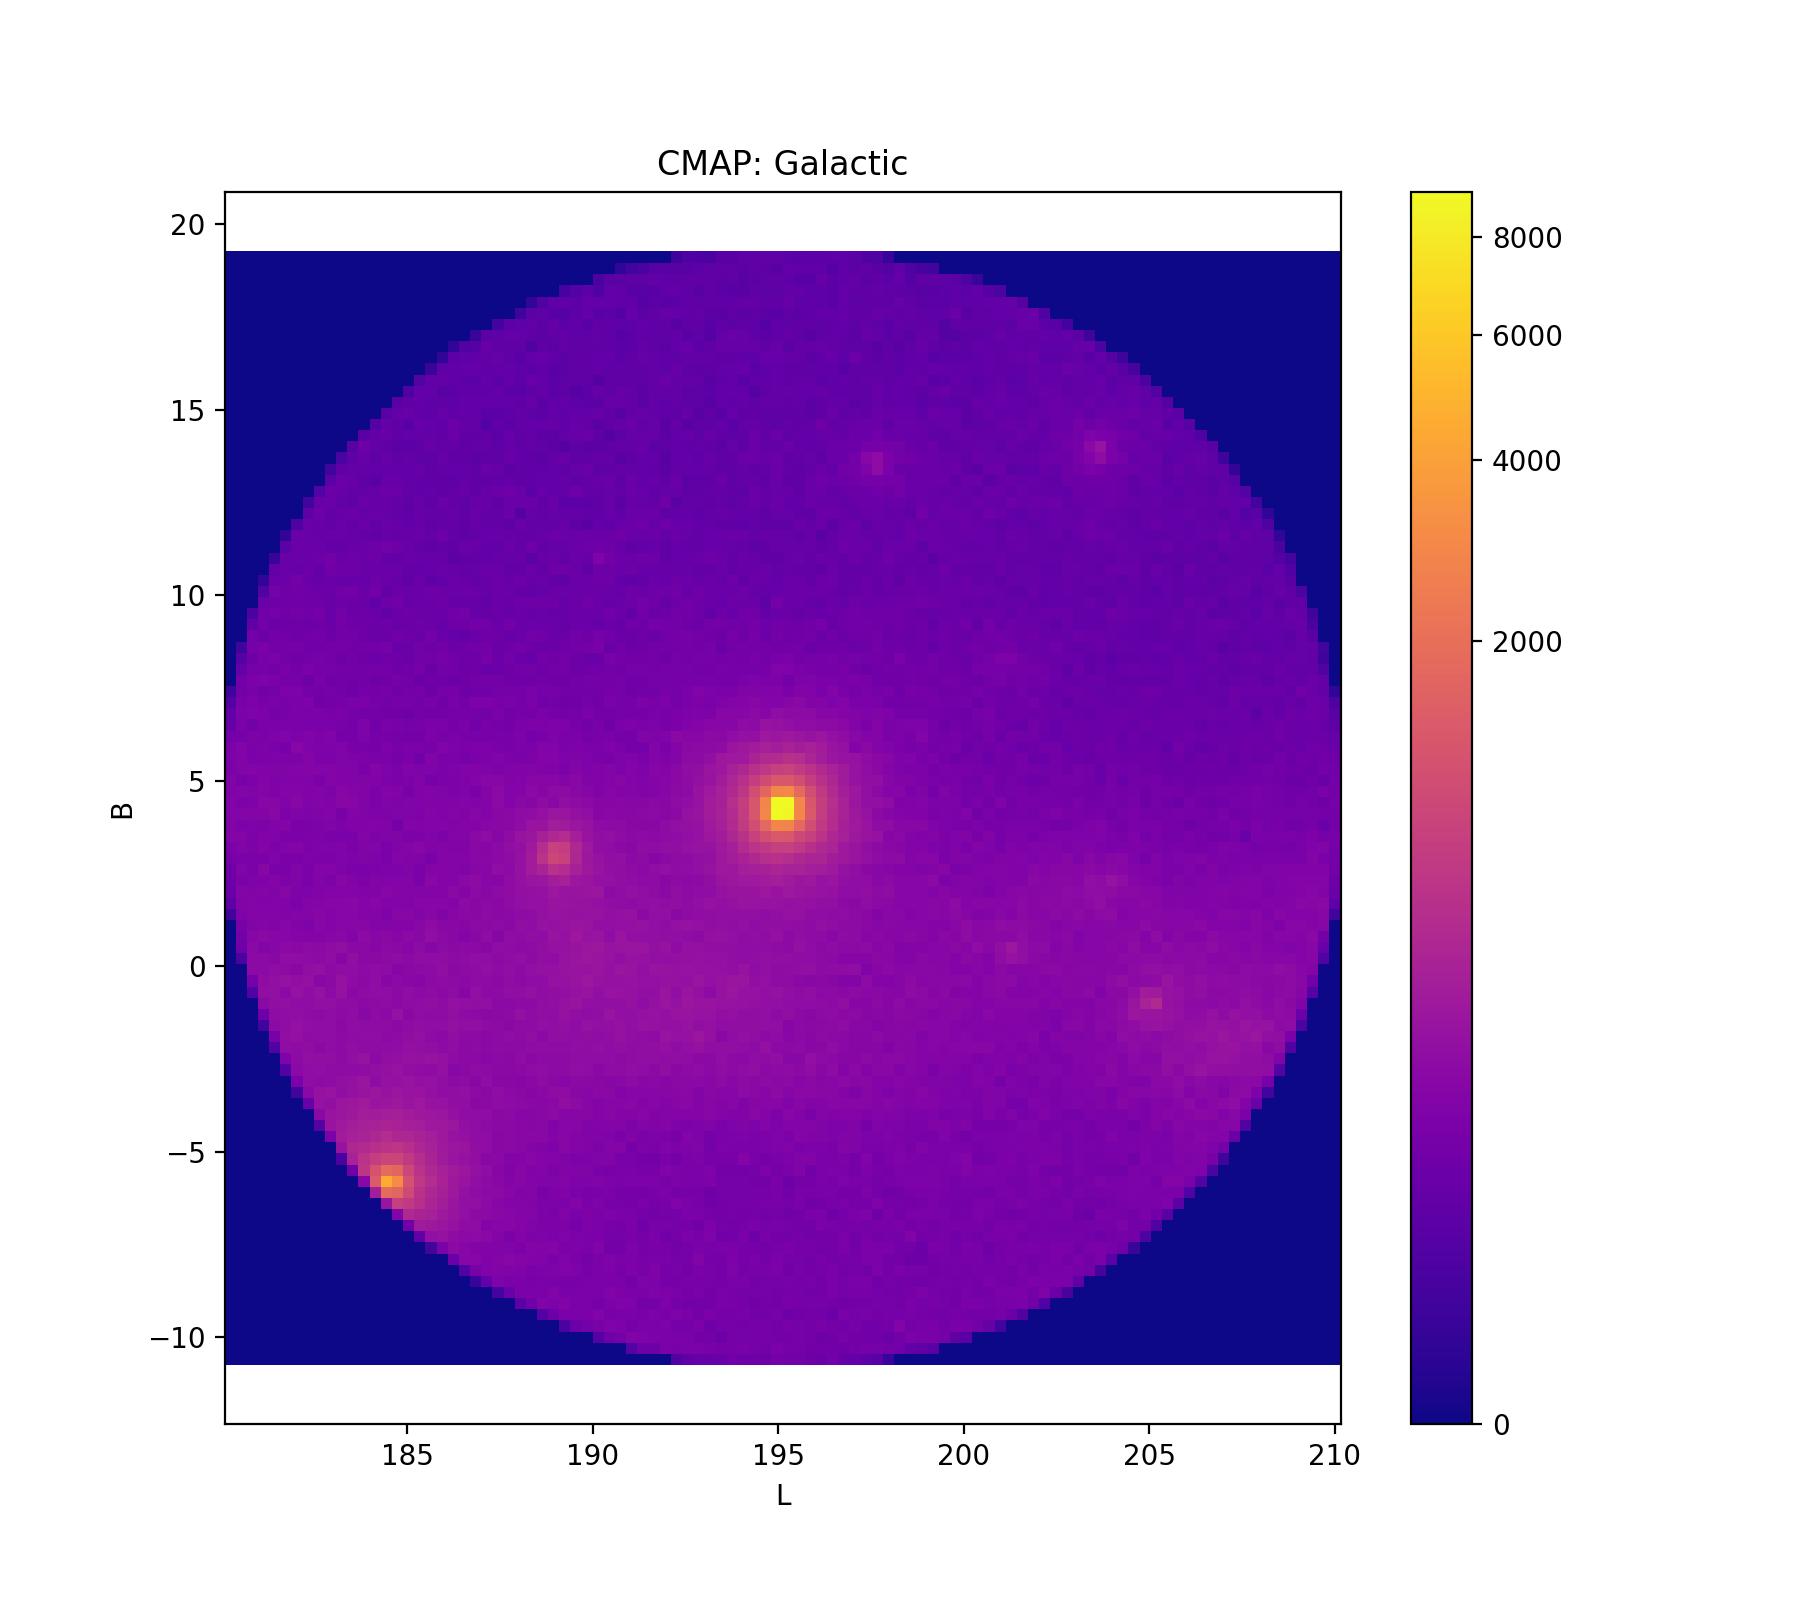

In [54]:
# We can now plot a count map of the events
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
ax.set(title='CMAP: Galactic',xlabel='L',ylabel='B')
h = ax.hist2d(geminga['L'],geminga['B'],100, cmap='plasma', norm=colors.PowerNorm(0.3) )# norm=colors.LogNorm())
ax.axis('equal')
fig.colorbar(h[3], ax=ax, orientation='vertical')

In [55]:
# Crop 1deg around Geminga (to shrink the file size and account for bad PSF)
ra  = 98.476204
dec = 17.770661
dist = np.sqrt( (geminga['RA']-ra)**2 + (geminga['DEC']-dec)**2) 
crop = geminga[dist<1]

In [56]:
crop

,ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,...,RUN_ID,RECON_VERSION,CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4,PULSE_PHASE
31817,1549.023071,98.863350,17.406977,195.627472,4.429537,50.741432,13.299020,39.663044,93.077927,2.395626e+08,...,239559565,0,0,5.770964,0.0,0.0,0.0,0.0,0.0,0.051843
31818,422.935028,98.076294,17.548695,195.157410,3.826344,47.923187,15.244350,35.484810,94.903145,2.395626e+08,...,239559565,0,1,60.089853,0.0,0.0,0.0,0.0,0.0,0.161839
31819,2065.372070,98.229301,17.838327,194.966156,4.088512,47.579494,15.877502,34.551243,94.806335,2.395626e+08,...,239559565,0,0,75.618635,0.0,0.0,0.0,0.0,0.0,0.660166
31820,1027.132812,98.616600,17.511015,195.427063,4.267377,45.022133,17.201035,30.606989,97.205437,2.395627e+08,...,239559565,0,0,21.389896,0.0,0.0,0.0,0.0,0.0,0.141166
31824,912.030457,98.663872,17.675556,195.300781,4.382473,44.138332,18.226542,28.834759,97.666725,2.395627e+08,...,239559565,0,0,49.349853,0.0,0.0,0.0,0.0,0.0,0.072278
31825,323.508301,98.490601,17.324980,195.538055,4.075516,43.001888,18.710297,27.376163,99.136551,2.395627e+08,...,239559565,0,0,71.838078,0.0,0.0,0.0,0.0,0.0,0.924344
31830,124.156410,98.500679,18.309753,194.663589,4.533223,36.236828,33.220066,7.441597,101.795631,2.395631e+08,...,239559565,0,0,132.556790,0.0,0.0,0.0,0.0,0.0,0.291280
31838,956.993591,98.525635,18.017120,194.935699,4.420980,39.609379,48.432247,19.198807,294.241241,2.395635e+08,...,239559565,0,1,127.753440,0.0,0.0,0.0,0.0,0.0,0.038899
31844,1067.755249,97.800568,18.113464,194.533752,3.852013,49.401882,47.811852,37.179970,295.612946,2.395638e+08,...,239559565,0,1,27.812509,0.0,0.0,0.0,0.0,0.0,0.055646
31845,908.039185,98.808533,18.255342,194.845627,4.768780,53.031395,44.653748,42.112530,296.459015,2.395638e+08,...,239559565,0,0,119.943214,0.0,0.0,0.0,0.0,0.0,0.638738


<IPython.core.display.Javascript object>


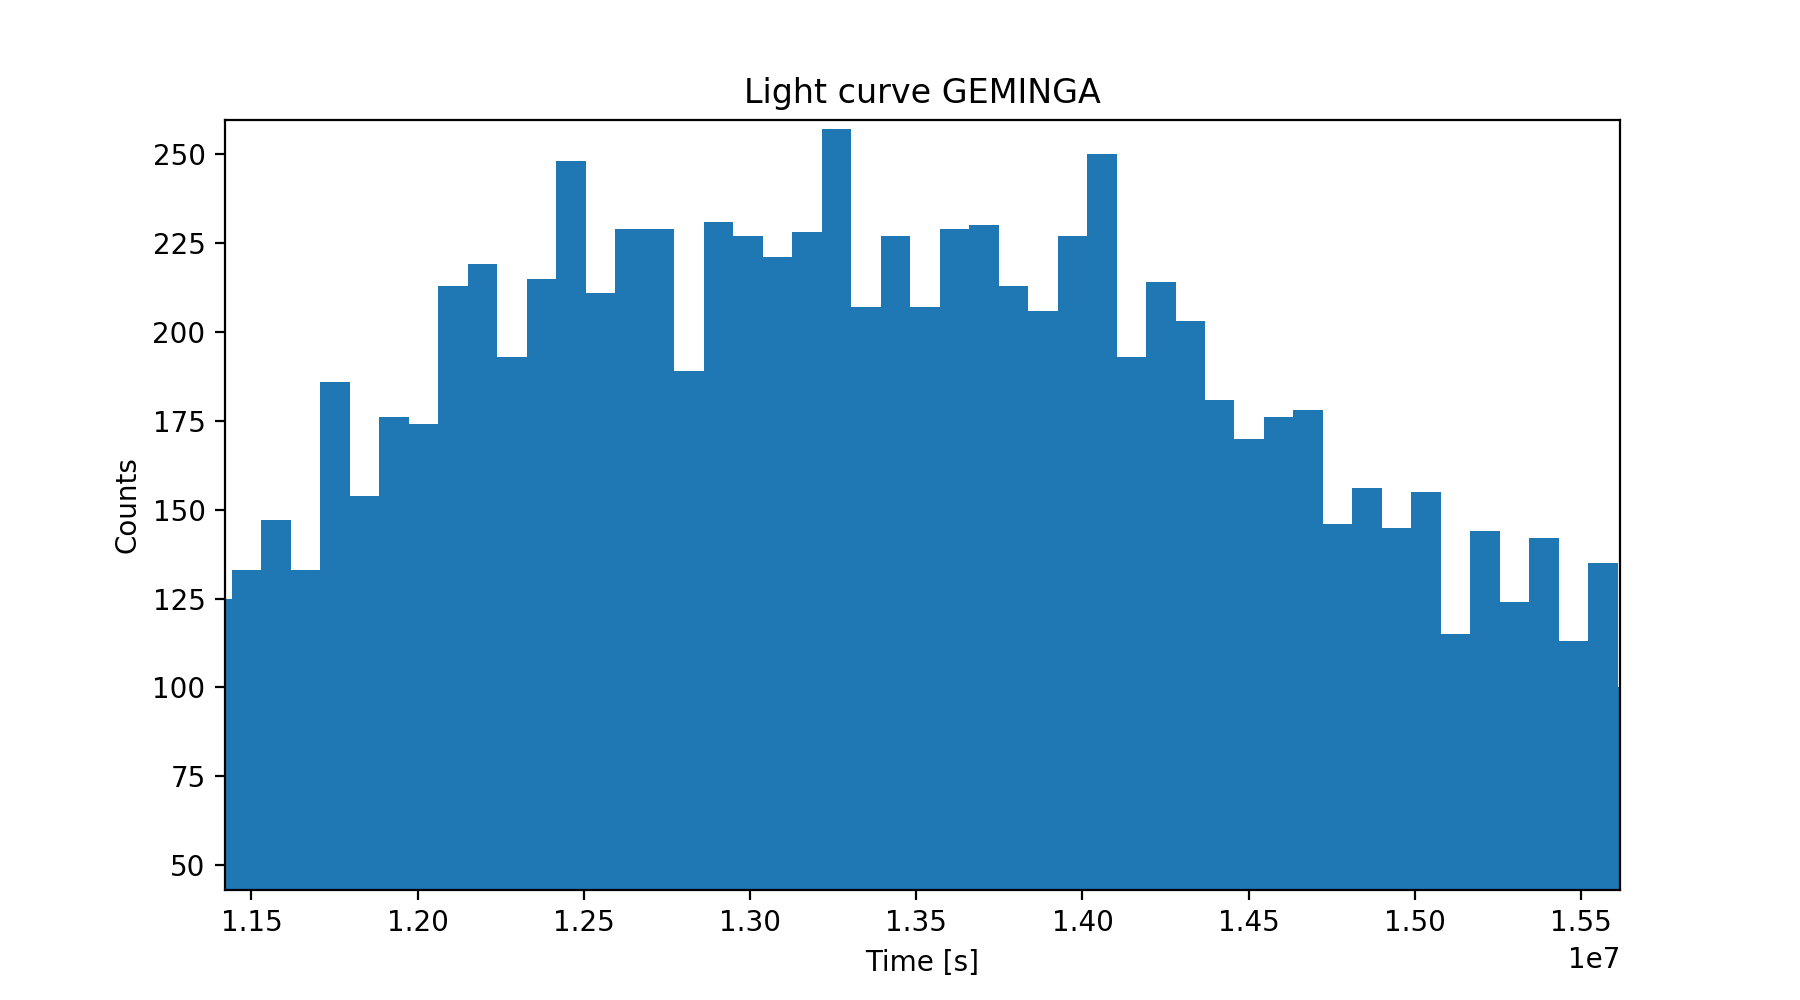

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.set(title='Light curve GEMINGA',xlabel='Time [s]',ylabel='Counts')
h = ax.hist(crop['TIME']-crop['TIME'].min(), 500)
#h = ax.hist(crop['TIME']-crop['TIME'].min(),range=(0,3600), bins=10)

In [ ]:
#Precession of the satellite orbit:
4.5e6/86400 # days

Because the LAT data are sparse, long accumulation time is required. Calculating a pulse phase therefore requires precise position and timing information for the pulsar.

In [ ]:
# The execution is VERY SLOW if we use ALL available data. So we reduce the time range
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))

# Select TIME range and FILTER OUT negative values
x = crop['TIME'][:100]
y = np.ones(len(x))

# Define the array of frequencies for which to compute the periodogram:
nout=100000
p = np.linspace(0.01, 2, nout)
ang_freqs = 2 * np.pi / p

# Calculate Lomb-Scargle periodogram:
pgram = signal.lombscargle(x, y, ang_freqs, normalize=True)

# Plot of the results:
ax[0].plot(x, y, '+')
ax[0].set(xlabel='Time [s]',ylabel='Rate [A.U.]',title='Geminga LC')
ax[1].plot(p, pgram)
ax[1].set(xlabel='period [s]',ylabel='A.U.',title='Periodogram: Lomb-Scargle')

for i,j in zip(p,pgram):
    if j==pgram.max():
        print('Best period = %s' % i)
fig.tight_layout()

In [45]:
# Lomb-Scargle does not work in this case. Let's try manually folde the LC
# Attribute PHASE to cropped Geminga
period = 1/4.217567
crop_dummy = crop.copy()
crop_dummy['PHASE'] = np.zeros(len(crop_dummy['TIME']))
for n,t in zip(crop_dummy.index,crop_dummy['TIME']):
    crop_dummy.loc[n,'PHASE'] = (t % period)/period

In [ ]:
# Plot FOLDED LC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Geminga FOLDED LC:')
ax[0].set(title='ALL data, P=%.4f' % period, xlabel='Time [s]', ylabel='Phase')#, ylim=(-0.01,0.05))
ax[0].plot(crop_dummy['TIME'],crop_dummy['PHASE'],',')

ax[1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='Counts')#, ylim=(-0.0007,0.012))
ax[1].hist(crop_dummy['PHASE'],200)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Pulse profile is FLAT... Why it does not work?

In [ ]:
# See HEADER file for further info
geminga_hdu[1].header

## Performing BARYCENTRIC correction with gtbary (or faxbary)

The telescope is moving around the Earth, which in turns move around the Sun. So we should refer to the arrival time at a point in the solar system which is at rest. Such a point is the system's centre of mass, the so-called solar system barycentre, which we assume to be comoving with the pulsar.  

If the assumed pulsar position is inaccurate, our transformation to the solar system barycentre will be wrong too, creating a deviation from the expected arrival time that depends on the position of the Earth in its orbit. Hence, the deviation will have a sinusoid shape with the period of one year.

![title](pics/bary.png)

![title](pics/bary_formula.png)

![title](pics/bary_formula_component.png)

In [47]:
# Load Geminga_bary files
roi_file = 'data/gtbary/Geminga_1deg_roi.fits'
roi = fits.open(roi_file)
roi_fits = fits.open(roi_file)[1].data
names = [name for name in roi_fits.columns.names if len(roi_fits[name].shape) <= 1]
roi = Table.read(roi_file,hdu=1)
roi = roi[names].to_pandas()

roi_geo_file = 'data/gtbary/Geminga_1deg_roi_geo.fits'
roi_geo = fits.open(roi_geo_file)
roi_geo_fits = fits.open(roi_geo_file)[1].data
names = [name for name in roi_geo_fits.columns.names if len(roi_geo_fits[name].shape) <= 1]
roi_geo = Table.read(roi_geo_file,hdu=1)
roi_geo = roi_geo[names].to_pandas()

roi_bary_file = 'data/gtbary/Geminga_1deg_roi_bary.fits'
roi_bary = fits.open(roi_bary_file)
roi_bary_fits = fits.open(roi_bary_file)[1].data
names = [name for name in roi_bary_fits.columns.names if len(roi_bary_fits[name].shape) <= 1]
roi_bary = Table.read(roi_bary_file,hdu=1)
roi_bary = roi_bary[names].to_pandas()

In [ ]:
# Count map of the cropped events (1deg)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
ax.set(title='CMAP: Galactic',xlabel='L',ylabel='B')
h = ax.hist2d(roi_bary['L'],roi_bary['B'],100, cmap='plasma', norm=colors.PowerNorm(0.3) )# norm=colors.LogNorm())
ax.axis('equal')
fig.colorbar(h[3], ax=ax, orientation='vertical')

In [ ]:
fits.open(roi_file)[1].header

In [ ]:
fits.open(roi_geo_file)[1].header

In [ ]:
fits.open(roi_bary_file)[1].header

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
h1 = ax[0].hist(roi['TIME']-roi_bary['TIME'],     range=(-505,505), bins=100, alpha=0.5, label='MET - TDB')
h2 = ax[0].hist(roi_bary['TIME']-roi_geo['TIME'], range=(-505,505), bins=100, alpha=0.5, label='TDB - TT')
h3 = ax[1].hist(roi['TIME']-roi_geo['TIME'],      bins=100, alpha=0.5, label='MET - TT')
ax[0].legend()
ax[1].legend()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(roi['TIME']-roi['TIME'].min(),roi['TIME']-roi_bary['TIME'],    ':+', label='MET - TDB')
ax.plot(roi['TIME']-roi['TIME'].min(),roi['TIME']-roi_geo['TIME'],     ':+', label='MET - TT')
ax.plot(roi['TIME']-roi['TIME'].min(),roi_geo['TIME']-roi_bary['TIME'],':+',label='TT - TDB')
#ax.set(xlim=(9.694e6,9.702e6), ylim=(-0.025,-0.005))
ax.axvline(1.26e7,ls=':')
#ax.axvline(1.26e7+0.5*np.pi*1e7,ls=':')
ax.axvline(1.26e7+np.pi*1e7,ls=':')
ax.legend()

# Look for Ephemeris which describes the source

![title](pics/ephemeris.png)

![title](pics/Taylor.png)

In [63]:
# Attribute a PHASE to Geminga barycentered photons: 1st order
period = 1/4.217567
f0 = 4.217567
f1 = -1.952503e-13
roi_bary_dummy = roi_bary.copy()
roi_bary_dummy['PHASE'] = np.zeros(len(roi_bary_dummy['TIME']))
for n,t in zip(roi_bary_dummy.index,roi_bary_dummy['TIME']):
    roi_bary_dummy.loc[n,'PHASE'] = (t % period)/period

In [ ]:
# Plot manually FOLDED LC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Geminga Barycentered photons FOLDED LC: 1st term')
ax[0].set(title='ALL data, P=%.4f' % period, xlabel='Time [s]', ylabel='Phase')#, ylim=(-0.01,0.05))
ax[0].plot(roi_bary_dummy['TIME'],roi_bary_dummy['PHASE'],',')

ax[1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='Counts')#, ylim=(-0.0007,0.012))
ax[1].hist(roi_bary_dummy['PHASE'],100)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

In [ ]:
# ZOOM IN FOLDED LC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Geminga Barycentered FOLDED LC: 1st term')
ax[0].set(title='ZOOM IN, P=%.4f' % period, xlabel='Time [s]', ylabel='Phase')#, ylim=(-0.01,0.05))
short = np.logical_and(roi_bary_dummy['TIME']>2.50e8,roi_bary_dummy['TIME']<2.51e8)
ax[0].plot(roi_bary_dummy['TIME'][short],roi_bary_dummy['PHASE'][short],'+')

ax[1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='Counts')#, ylim=(-0.0007,0.012))
ax[1].hist(roi_bary_dummy['PHASE'][short],40)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

In [66]:
# Attribute a PHASE to Geminga barycentered photons: 2nd order (and T_0)
period = 1/4.217567
f0 = 4.217567
f1 = -1.952503e-13
t0 = (54800-51910)*86400.

roi_bary_dummy2 = roi_bary.copy()
roi_bary_dummy2['PHASE'] = np.zeros(len(roi_bary_dummy2['TIME']))

for n,t in zip(roi_bary_dummy2.index,roi_bary_dummy2['TIME']):
    roi_bary_dummy2.loc[n,'PHASE'] = ((t-t0)*f0 + 0.5*((t-t0)**2)*f1)%1

In [ ]:
# Plot new FOLDED LC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Geminga Barycentered FOLDED LC: with Fdot')
ax[0].set(title='ALL data, P=%.4f' % period, xlabel='Time [s]', ylabel='Phase')#, ylim=(-0.01,0.05))
ax[0].plot(roi_bary_dummy2['TIME'],roi_bary_dummy2['PHASE'],',')

ax[1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='Counts')#, ylim=(-0.0007,0.012))
ax[1].hist(roi_bary_dummy2['PHASE'],100)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

In [ ]:
# ZOOMING FOLDED LC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
fig.suptitle('Geminga Barycentered FOLDED LC: with Fdot')
ax[0].set(title='ZOOM IN, P=%.4f' % period, xlabel='Time [s]', ylabel='Phase')#, ylim=(-0.01,0.05))
short = np.logical_and(roi_bary_dummy2['TIME']>2.50e8,roi_bary_dummy2['TIME']<2.51e8)
ax[0].plot(roi_bary_dummy2['TIME'][short],roi_bary_dummy2['PHASE'][short],'+')

ax[1].set(title='BINNED data, P=%.4f' % period, xlabel='Phase', ylabel='Counts')#, ylim=(-0.0007,0.012))
ax[1].hist(roi_bary_dummy2['PHASE'][short],40)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Look for Ephemeris database

https://fermi.gsfc.nasa.gov/ssc/data/access/lat/ephems/

![title](pics/database.png)

In [ ]:
# Load photon files
db_file = 'data/database.fits'
fits.info(db_file)

In [ ]:
# LOAD data with PANDAS and look at the tables
#geminga_ft = fits.open(geminga_file)[1].data
#names = [name for name in geminga_ft.columns.names if len(geminga_ft[name].shape) <= 1]
db = Table.read(db_file,hdu=1).to_pandas()
db

We run now "gtpphase":
![title](pics/gtpphase_DB.png)

In [ ]:
# Plot the folded light curve profile
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
ax.set(title='Folded light curve',xlabel='Phase',ylabel='Counts',xlim=(0,1))
ax.hist(geminga['PULSE_PHASE'],100)
#ax.hist(crop['PULSE_PHASE'],100)

If we do not have any database, we can manually input the Ephemeris, always via "gtpphase":
![title](pics/gtpphase_manual.png)

In [ ]:
'''
# Load photon files
geminga_file_man = 'data/Geminga_gtis.fits'
# LOAD data with PANDAS and look at the EVENT table
geminga_ft_man = fits.open(geminga_file)[1].data
names = [name for name in geminga_ft_man.columns.names if len(geminga_ft_man[name].shape) <= 1]
geminga_man = Table.read('data/Geminga_gtis.fits',hdu=1)
geminga_man = geminga_man[names].to_pandas()
geminga_man
'''

In [ ]:
'''
# Plot the folded light curve profile
nbin = 100
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
ax.set(title='Folded light curve MANUALLY',xlabel='Phase',ylabel='Counts',xlim=(0,1))
ax.hist(geminga_man['PULSE_PHASE'],nbin)

# Define ON-PULSE, OFF-PULSE & INTER-PULSE:
off_pulse   = np.logical_and(geminga['PULSE_PHASE']>0.22,geminga['PULSE_PHASE']<0.58)
on_pulse    = np.logical_and(geminga['PULSE_PHASE']>0.22,geminga['PULSE_PHASE']<0.58)
inter_pulse = np.logical_or(geminga['PULSE_PHASE']<0.05,geminga['PULSE_PHASE']>0.72)
ax.axvline(0.05,ls=':',color='r', linewidth=4)
ax.axvline(0.22,ls=':',color='r', linewidth=4)
ax.axvline(0.58,ls=':',color='r', linewidth=4)
ax.axvline(0.72,ls=':',color='r', linewidth=4)
ax.axhline(np.sum(off_pulse)/(100*(0.58-0.22)),xmin=0.22, xmax=0.58,ls=':',color='k', linewidth=4)
ax.axhline(np.sum(inter_pulse)/(100*(0.05+1-0.72)), xmax=0.05,ls=':',color='k', linewidth=4)
ax.axhline(np.sum(inter_pulse)/(100*(0.05+1-0.72)),xmin=0.72,ls=':',color='k', linewidth=4)
'''

In [ ]:
# Plot the folded light curve profile
nbin = 100
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))
ax.set(title='Folded light curve',xlabel='Phase',ylabel='Counts',xlim=(0,1))
ax.hist(crop['PULSE_PHASE'],nbin)

# Define ON-PULSE, OFF-PULSE & INTER-PULSE:
off_pulse   = np.logical_and(crop['PULSE_PHASE']>0.22,crop['PULSE_PHASE']<0.58)
on_pulse    = np.logical_and(crop['PULSE_PHASE']>0.22,crop['PULSE_PHASE']<0.58)
inter_pulse = np.logical_or( crop['PULSE_PHASE']<0.05,crop['PULSE_PHASE']>0.72)
ax.axvline(0.05,ls=':',color='r', linewidth=4)
ax.axvline(0.22,ls=':',color='r', linewidth=4)
ax.axvline(0.58,ls=':',color='r', linewidth=4)
ax.axvline(0.72,ls=':',color='r', linewidth=4)
ax.axhline(np.sum(off_pulse)/(100*(0.58-0.22)),xmin=0.22, xmax=0.58,ls=':',color='k', linewidth=4)
ax.axhline(np.sum(inter_pulse)/(100*(0.05+1-0.72)), xmax=0.05,ls=':',color='k', linewidth=4)
ax.axhline(np.sum(inter_pulse)/(100*(0.05+1-0.72)),xmin=0.72,ls=':',color='k', linewidth=4)

"gtpphase":
![title](pics/pulse_profile.png)

In [ ]:
# We can now plot a count map of the events
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle('CMAP: GEMINGA')
ax[0].set(title='ALL events',xlabel='L',ylabel='B')
h = ax[0].hist2d(geminga['L'],geminga['B'],200, cmap='plasma', norm=colors.PowerNorm(0.3) )# norm=colors.LogNorm())
ax[0].axis('equal')
fig.colorbar(h[3], ax=ax[0], orientation='vertical')

off_pulse   = np.logical_and(geminga['PULSE_PHASE']>0.22,geminga['PULSE_PHASE']<0.58)
on_pulse    = np.logical_and(geminga['PULSE_PHASE']>0.22,geminga['PULSE_PHASE']<0.58)
inter_pulse = np.logical_or( geminga['PULSE_PHASE']<0.05,geminga['PULSE_PHASE']>0.72)

ax[1].set(title='OFF-PULSE (36% of TOTAL exposure)',xlabel='L',ylabel='B')
h = ax[1].hist2d(geminga['L'][off_pulse],geminga['B'][off_pulse],200, cmap='plasma', norm=colors.PowerNorm(0.3) )# norm=colors.LogNorm())
ax[1].axis('equal')
fig.colorbar(h[3], ax=ax[1], orientation='vertical')

In [ ]:
# Getting back to System references
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
h1 = ax[0].hist(roi['TIME']-roi_bary['TIME'],     range=(-505,505), bins=100, alpha=0.5, label='MET - TDB')
h2 = ax[0].hist(roi_bary['TIME']-roi_geo['TIME'], range=(-505,505), bins=100, alpha=0.5, label='TDB - TT')
h3 = ax[1].hist(roi['TIME']-roi_geo['TIME'],      bins=100, alpha=0.5, label='MET - TT')
ax[0].legend()
ax[1].legend()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(roi['TIME']-roi['TIME'].min(),roi['TIME']-roi_bary['TIME'],    ':+', label='MET - TDB')
ax.plot(roi['TIME']-roi['TIME'].min(),roi['TIME']-roi_geo['TIME'],     ':+', label='MET - TT')
ax.plot(roi['TIME']-roi['TIME'].min(),roi_geo['TIME']-roi_bary['TIME'],':+',label='TT - TDB')
#ax.set(xlim=(9.694e6,9.702e6), ylim=(-0.025,-0.005))
ax.set(xlim=(1.2665e7,1.268e7), ylim=(-490.90,-490.86))
ax.legend()

In [89]:
# Funny EXTRA...
# ...A way to estimate the satellite ORBIT DURATION
x = roi['TIME']-roi['TIME'].min()
orbit1 = np.logical_and(x>1.2665e7,x<1.2668e7)
orbit2 = np.logical_and(x>1.267e7,x<1.2674e7)

y1 = (roi['TIME']-roi_geo['TIME'])[orbit1].min()
for i,j in zip(roi['TIME'][orbit1].index,(roi['TIME']-roi_geo['TIME'])[orbit1]):
    if j==y1:
        print('Min value at index %s, corresponding to time %s sec' % (i,roi['TIME'][i]))
y2 = (roi['TIME']-roi_geo['TIME'])[orbit2].min()
for k,j in zip(roi['TIME'][orbit2].index,(roi['TIME']-roi_geo['TIME'])[orbit2]):
    if j==y2:
        print('Min value at index %s, corresponding to time %s sec' % (k,roi['TIME'][k]))
orbit_sec = (roi['TIME'][k]-roi['TIME'][i])
print('Orbit duration: %.2f sec = %.2f min = %.2f hour' % (orbit_sec,orbit_sec/60,orbit_sec/3600))

Min value at index 26102, corresponding to time 252229021.0398862 sec
Min value at index 26123, corresponding to time 252234900.4928299 sec
Orbit duration: 5305.09 sec = 88.42 min = 1.47 hour


Note: Since the pulsar location is needed to calculate photon travel time between the spacecraft and the geocenter, in principle everything after a geocentric conversion depends on the pulsar location.

TT = TAI (International Atomic Time) + 32.184 s

TAI = UTC + 32 s at January 1.0, 2001, UTC

Approximately, TDB = TT + 1.658 ms × sin g + 0.014 ms × sin 2g, where g is a mean anomaly of the center of gravity of the Earth-Moon system around the Sun. More precise estimate is necessary to meet the requirement on absolute time accuracy for Fermi (formerly GLAST).

The solar system barycenter is located near the surface of the Sun, which is 2.3 light-second away from the center of the Sun.

For micro-second precision timing, relativistic effects are not negligible. Such effects include: the Shapiro delay in the solar system, aberration due to the motion of the spacecraft around the Earth and the motion of the Earth around the Sun, and relativistic delay at the source (for binary pulsars only).

Also see Goddard Space Flight Center's "A Time Tutorial" in "The ABC of XTE" for basic information about temporal analyses.

## ...Play with the notebook... and have FUN...